In [1]:
import os
import sys
import re
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
# for building model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter

from scipy.stats import chi2_contingency, f_oneway # For statistical tests
from nltk.stem import WordNetLemmatizer

from IPython.core.display import HTML
from IPython.display import Image

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.functions.image import get_image_base64
help(get_image_base64)

plt.style.use('dark_background')

# DATA_LANGUAGE = 'english'
DATA_LANGUAGE = 'french'
# DATA_TEST_LENGTH = 50
DATA_TEST_LENGTH = 0 # 0 means full data

Help on function get_image_base64 in module src.functions.image:

get_image_base64(image_path)
    Converts an image file to a Base64 string for embedding in HTML.



In [2]:
df_train_x = pd.read_csv('../data/X_train_update.csv')
df_train_y = pd.read_csv('../data/Y_train_CVw08PX.csv')
df_test_x = pd.read_csv('../data/X_test_update.csv')

# print('***** X_train_update *****')
# print(df_train_x.head())
# print('***** Y_train_CVw08PX *****')
# print(df_train_y.head())
# print('***** X_test_update *****')
# print(df_test_x.head())

In [3]:
# print(df_train_x.isna().any())
# df_train_x.isnull().sum()

In [4]:
# print('Dimensions of the dataset: ', df_train_x.shape, '\n\n')
# print('Summary of dataset: ', df_train_x.info())

In [5]:
# print( df_train_x.describe() )

In [6]:
def train(model, x_train, x_test, y_train):
    model.fit(x_train, y_train)
    
    # predict the results
    pred = model.predict(x_test)
    
    print('Results')

    
model = LinearRegression()
# train(model, X, y)

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalized notebook / 150 pages / point grid / CA DIN A5 / rose design,NaN,3804725264,
1,1,Journal of the Arts (Le) n ° 133 of 09/28/2001 - Art and its Asian art salon in Paris - Jacques Barre - Francois Perrier - The reform of sales in public entitles - SNA feet its hundred years.,NaN,436067568,
2,2,Large Ergonomic Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,Pilot Touch Pen style Speedlink is 1 ergonomic stylus for gamepad nintendo wii u. for optimal comfort and maximum precision on the gamepad of the Wii U: this large highly ergonomic stylus is not only perfectly adapted to your hand but also very elegant. It is delivered with a support that fixes without adhesive Gamepad Characteristics: Model: Speedlink Pilot Touch Pen Color: Blue Ref. Manufacturer: SL-3468-Be Compatibility: Gamepad Nintendo Wii U Particularly ergonomic shape Excellent handling Long-term coating point designed to avoid damaging the touch screen as a bonus: Support included for gamepad <,201115110,

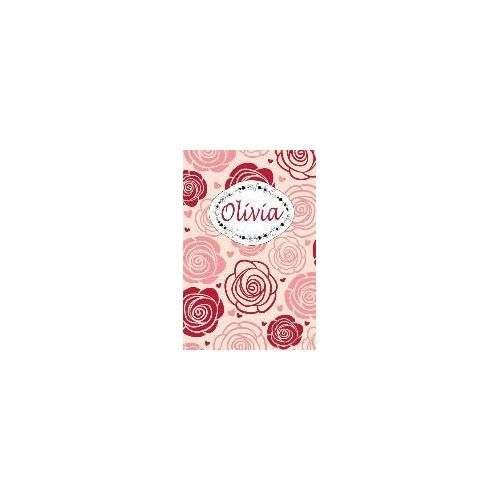
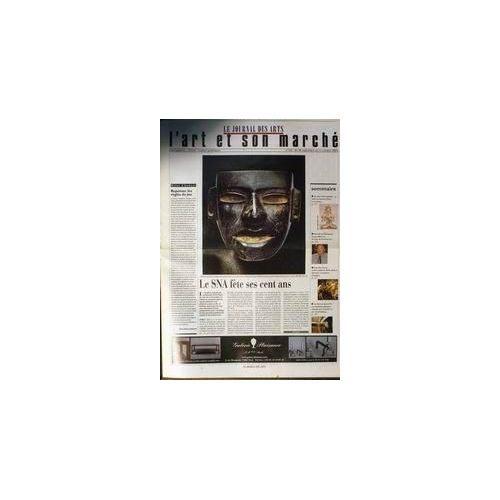
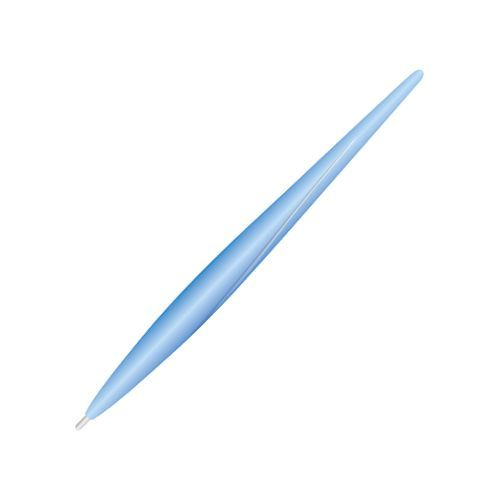

In [7]:
from auto_translate import AutoTranslate
translate = AutoTranslate("en")

IMG_PATH = "../data/images/image_train/"
pd.set_option('display.max_colwidth', None)
image_cols = ['imageid']
translate_cols = ['designation', 'description']

def format_value(val, row, col, productid):
    return f"{IMG_PATH}image_{val}_product_{productid}.jpg"
    
def format_row(row):
    for col in image_cols:
        row[col] = format_value(row[col], row.name, col, row.productid)
    return row    

def path_to_image_html(path):
    if os.path.exists(path):
        encoded_img, mime_type = get_image_base64(path)
        return f'<img src="data:{mime_type};base64,{encoded_img}" width="300">'
    else:
        return 'Image not found'

def translation(text):
    return translate.translate(text)
    
# Create the dictionariy to be passed as formatters
format_dict = {}
for image_col in image_cols:
    format_dict[image_col] = path_to_image_html
for translate_col in translate_cols:
    format_dict[translate_col] = translation

df_test = df_train_x.head(3).apply(format_row, axis=1)
# df_test
display(HTML(df_test.to_html(escape=False ,formatters=format_dict))) 
df_test.to_html('df_train_x.html', escape=False ,formatters=format_dict)

# Image(filename = IMG_PATH + "image_1263597046_product_3804725264.jpg", width=100, height=100)

In [8]:
# Download NLTK data (run this once)
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except:
    nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/sameer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
X_train = df_train_x
Y_train = df_train_y

# Merge X_train and Y_train to have features and labels together for training data
train_df = pd.merge(X_train, Y_train, how='left')
# train_df.head(5)


--- Missing Values ---

--- Distribution of Product Categories (prdtypecode) ---


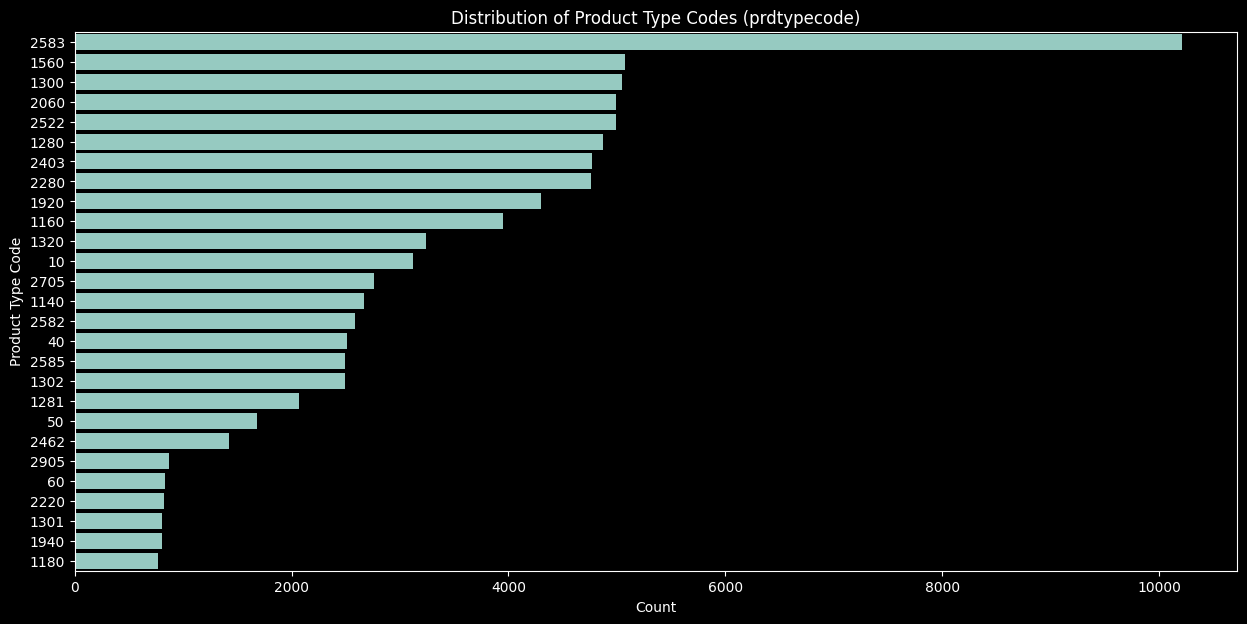


--- Text Length Analysis ---


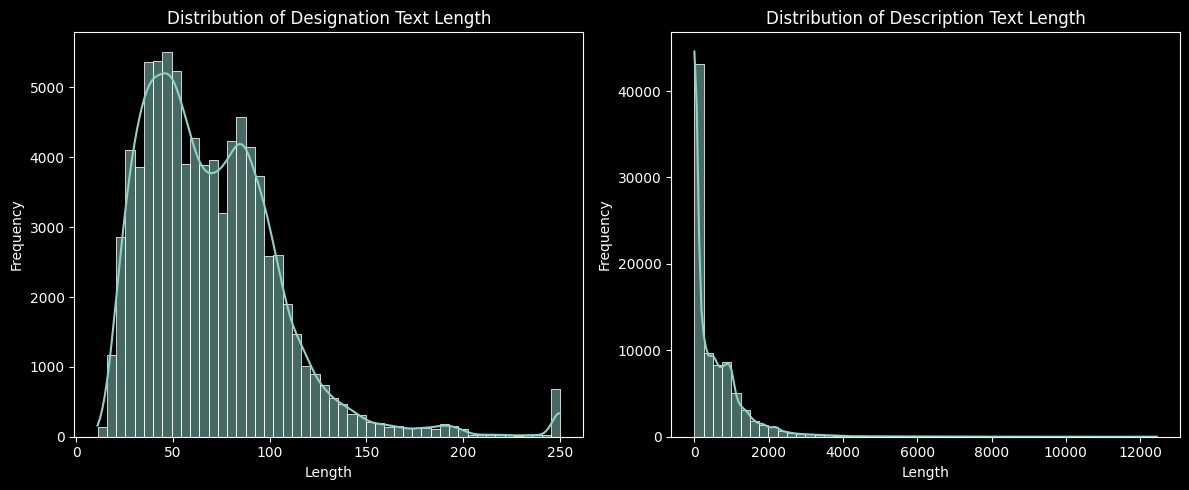

In [13]:
X_train = df_train_x.head(DATA_TEST_LENGTH) if DATA_TEST_LENGTH != 0 else df_train_x
X_test = df_test_x.head(DATA_TEST_LENGTH) if DATA_TEST_LENGTH != 0 else df_test_x
Y_train = df_train_y.head(DATA_TEST_LENGTH) if DATA_TEST_LENGTH != 0 else df_train_y

# Merge X_train and Y_train to have features and labels together for training data
train_df = pd.merge(X_train, Y_train, how='left')
# train_df.head()
# print("\nMerged training data (train_df) shape:", train_df.shape)
# print("\n--- Merged Train_df Info ---")
# train_df.info()
# print("\n--- Merged Train_df Head ---")
# print(train_df.head())

# --- 3. Perform Data Exploration (EDA) ---
# print("\n--- Missing Values ---")
# print("Missing values in X_train:\n", X_train.isnull().sum())
# print("Missing values in X_test:\n", X_test.isnull().sum())
# print("Missing values in Y_train:\n", Y_train.isnull().sum())
# print("Missing values in merged train_df:\n", train_df.isnull().sum())

# Handle missing values: Fill NaN descriptions with empty string for text processing
# It's better to treat NaN as empty string rather than 'nan' word
train_df['description'] = train_df['description'].fillna('')
X_test['description'] = X_test['description'].fillna('')
# print("\nMissing values in merged train_df after filling 'description':\n", train_df.isnull().sum())
# print("Missing values in X_test after filling 'description':\n", X_test.isnull().sum())

print("\n--- Distribution of Product Categories (prdtypecode) ---")
plt.figure(figsize=(15, 7))
sns.countplot(y='prdtypecode', data=train_df, order=train_df['prdtypecode'].value_counts().index)
plt.title('Distribution of Product Type Codes (prdtypecode)')
plt.xlabel('Count')
plt.ylabel('Product Type Code')
plt.show()
# print("\nNumber of unique product categories:", train_df['prdtypecode'].nunique())
# print("Top 10 product categories:\n", train_df['prdtypecode'].value_counts().head(10))

# Text length analysis
print("\n--- Text Length Analysis ---")
train_df['designation_len'] = train_df['designation'].apply(len)
train_df['description_len'] = train_df['description'].apply(len)
# print("\nDesignation text length statistics:")
# print(train_df['designation_len'].describe())
# print("\nDescription text length statistics:")
# print(train_df['description_len'].describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['designation_len'], bins=50, kde=True)
plt.title('Distribution of Designation Text Length')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(train_df['description_len'], bins=50, kde=True)
plt.title('Distribution of Description Text Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [15]:
# Combine text for overall analysis if needed
train_df['text_combined'] = train_df['designation'] + ' ' + train_df['description']

# --- 4. Data Pre-processing ---
print("\n--- Text Pre-processing ---")
stop_words = set(stopwords.words(DATA_LANGUAGE))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower() # Ensure text is string and lowercase
    text = re.sub(r'[^a-z\s]', '', text) # Remove non-alphabetic characters
    words = text.split()
    words = [word for word in words if word not in stop_words] # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words] # Lemmatization
    # words = [stemmer.stem(word) for word in words] # Stemming (optional, can try both lemmatization or stemming)
    return ' '.join(words)

# Apply pre-processing to combined text for analysis
train_df['cleaned_text'] = train_df['text_combined'].apply(preprocess_text)
X_test['cleaned_designation'] = X_test['designation'].apply(preprocess_text)
X_test['cleaned_description'] = X_test['description'].apply(preprocess_text)
X_test['cleaned_text'] = X_test['cleaned_designation'] + ' ' + X_test['cleaned_description']
print("\nOriginal text example (train_df['text_combined'][0]):\n", train_df['text_combined'][0])
print("\nCleaned text example (train_df['cleaned_text'][0]):\n", train_df['cleaned_text'][0])

# Most common words in cleaned text
all_words = ' '.join(train_df['cleaned_text']).split()
most_common_words = Counter(all_words).most_common(20)
print("\nMost Common Words in Cleaned Text (Top 20):\n", most_common_words)

# --- Save processed data (optional, for next steps) ---
# train_df.to_csv('processed_train_df.csv', index=False)
# X_test.to_csv('processed_X_test.csv', index=False)
# print("\nProcessed data saved to 'processed_train_df.csv' and 'processed_X_test.csv'.")


--- Text Pre-processing ---

Original text example (train_df['text_combined'][0]):
 Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design 

Cleaned text example (train_df['cleaned_text'][0]):
 olivia personalisiertes notizbuch seiten punktraster ca din a rosendesign

Most Common Words in Cleaned Text (Top 20):
 [('x', 92096), ('cm', 52140), ('br', 44476), ('taille', 24873), ('a', 23914), ('couleur', 23471), ('plus', 22295), ('piscine', 22064), ('peut', 21185), ('p', 19079), ('haute', 18615), ('qualit', 16669), ('pc', 16524), ('tre', 15757), ('mm', 15115), ('the', 14481), ('dimension', 12912), ('facile', 12880), ('matriel', 12768), ('tout', 12605)]


# A validation of the observation by data manipulation or a statistical test.

In [17]:
print("\n--- A Validation of Observations by Data Manipulation & Statistical Tests ---")
# Pre-processing steps similar to previous session (important for text analysis)
train_df['description'] = train_df['description'].fillna('')
train_df['designation_len'] = train_df['designation'].apply(len)
train_df['description_len'] = train_df['description'].apply(len)
train_df['text_combined'] = train_df['designation'] + ' ' + train_df['description']

stop_words = set(stopwords.words(DATA_LANGUAGE))
lemmatizer = WordNetLemmatizer()

def preprocess_text_for_validation(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

train_df['cleaned_text'] = train_df['text_combined'].apply(preprocess_text_for_validation)


--- A Validation of Observations by Data Manipulation & Statistical Tests ---



1.1. Validating Class Imbalance (Top/Bottom 10 Classes)


Text(0, 0.5, 'Product Type Code')

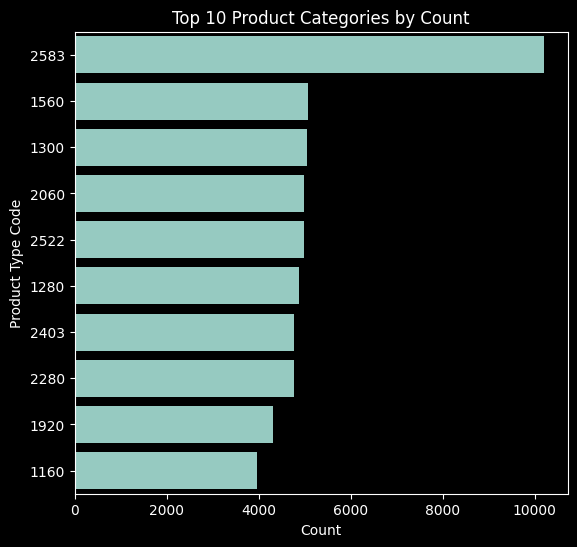

In [18]:
# --- 1. Data Manipulation Examples ---
# Observation 1: Class Imbalance (Re-confirming and visualizing impact)
print("\n1.1. Validating Class Imbalance (Top/Bottom 10 Classes)")
plt.figure(figsize=(14, 6))
# Top 10 classes
plt.subplot(1, 2, 1)
top_classes = train_df['prdtypecode'].value_counts().head(10)
sns.barplot(x=top_classes.values, y=top_classes.index.astype(str))
plt.title('Top 10 Product Categories by Count')
plt.xlabel('Count')
plt.ylabel('Product Type Code')

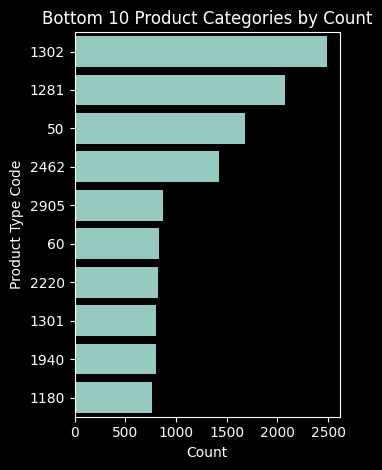

Total unique classes: 27
Count of most frequent class (2583): 10209
Count of least frequent class (1180): 764
Observation: Confirmed significant class imbalance. This will impact modeling strategies (e.g., weighted loss, resampling).


In [19]:
# Bottom 10 classes (might indicate long tail or rare categories)
plt.subplot(1, 2, 2)
bottom_classes = train_df['prdtypecode'].value_counts().tail(10)
sns.barplot(x=bottom_classes.values, y=bottom_classes.index.astype(str))
plt.title('Bottom 10 Product Categories by Count')
plt.xlabel('Count')
plt.ylabel('Product Type Code')
plt.tight_layout()
plt.show()

print(f"Total unique classes: {train_df['prdtypecode'].nunique()}")
print(f"Count of most frequent class ({top_classes.index[0]}): {top_classes.values[0]}")
print(f"Count of least frequent class ({bottom_classes.index[-1]}): {bottom_classes.values[-1]}")
print("Observation: Confirmed significant class imbalance. This will impact modeling strategies (e.g., weighted loss, resampling).")


1.2. Validating Text Length Differences Across Product Categories (Top 5 Classes)


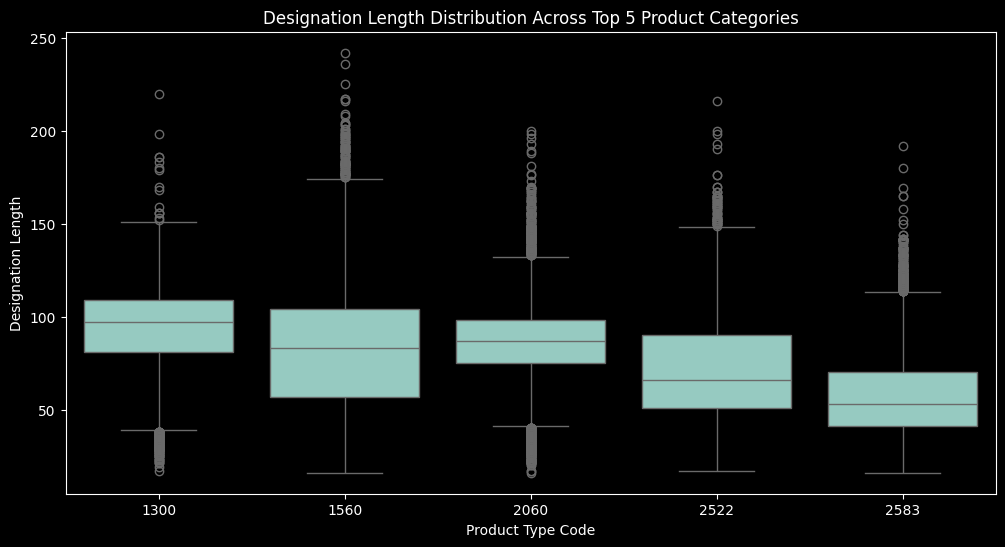

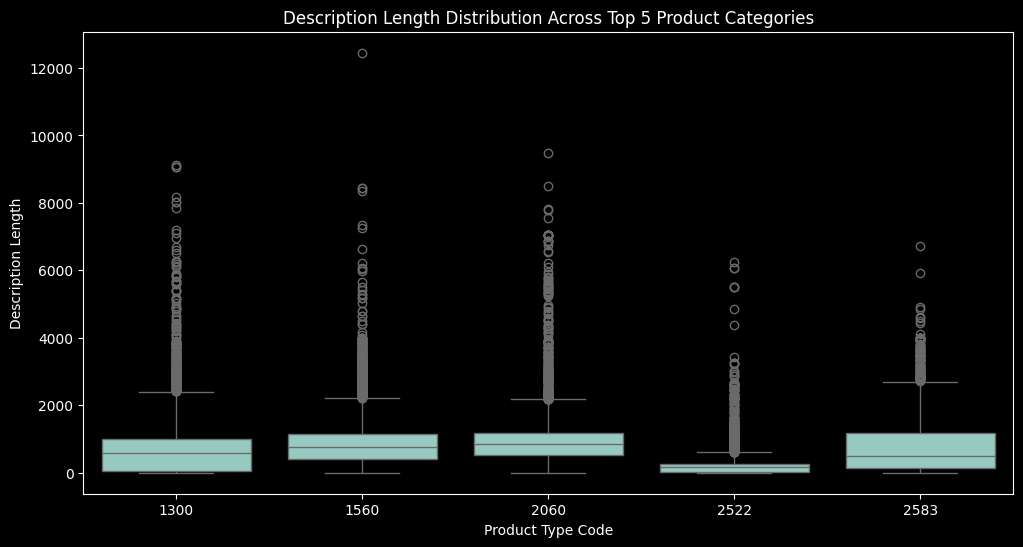

PrdType 2583: Avg Designation Len = 57.56, Avg Description Len = 718.85
PrdType 1560: Avg Designation Len = 83.28, Avg Description Len = 922.25
PrdType 1300: Avg Designation Len = 92.03, Avg Description Len = 765.40
PrdType 2060: Avg Designation Len = 85.84, Avg Description Len = 1012.44
PrdType 2522: Avg Designation Len = 72.89, Avg Description Len = 260.33
Observation: Noticeable differences in text lengths across categories could serve as useful features.


In [20]:
# Observation 2: Text Length Differences Across Product Categories
print("\n1.2. Validating Text Length Differences Across Product Categories (Top 5 Classes)")
# Select top 5 product categories for detailed analysis
top_5_prdtypecodes = train_df['prdtypecode'].value_counts().head(5).index

plt.figure(figsize=(12, 6))
sns.boxplot(x='prdtypecode', y='designation_len', data=train_df[train_df['prdtypecode'].isin(top_5_prdtypecodes)])
plt.title('Designation Length Distribution Across Top 5 Product Categories')
plt.xlabel('Product Type Code')
plt.ylabel('Designation Length')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='prdtypecode', y='description_len', data=train_df[train_df['prdtypecode'].isin(top_5_prdtypecodes)])
plt.title('Description Length Distribution Across Top 5 Product Categories')
plt.xlabel('Product Type Code')
plt.ylabel('Description Length')
plt.show()

for prd_code in top_5_prdtypecodes:
    design_len_mean = train_df[train_df['prdtypecode'] == prd_code]['designation_len'].mean()
    desc_len_mean = train_df[train_df['prdtypecode'] == prd_code]['description_len'].mean()
    print(f"PrdType {prd_code}: Avg Designation Len = {design_len_mean:.2f}, Avg Description Len = {desc_len_mean:.2f}")

print("Observation: Noticeable differences in text lengths across categories could serve as useful features.")


1.3. Validating Impact of Missing Descriptions on Product Type Distribution
Proportion of products with/without descriptions per category (sample):
 has_description         0         1
prdtypecode                        
10               0.891528  0.108472
40               0.654705  0.345295
50               0.283165  0.716835
60               0.159856  0.840144
1140             0.646200  0.353800


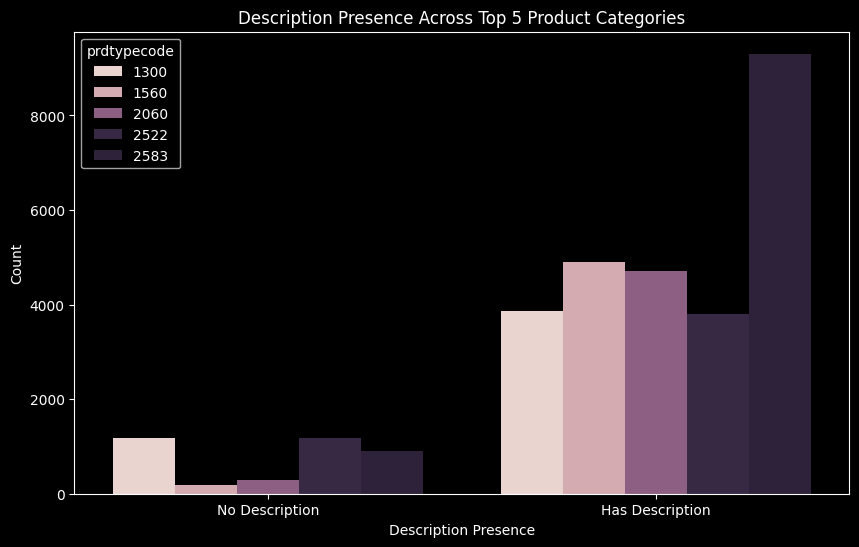

Observation: Some categories might heavily rely on descriptions while others less so. This informs feature engineering strategy.


In [21]:
# Observation 3: Impact of Missing Descriptions (Nulls) on Product Type Distribution
print("\n1.3. Validating Impact of Missing Descriptions on Product Type Distribution")
# Create a binary column for presence/absence of description
train_df['has_description'] = train_df['description'].apply(lambda x: 1 if x else 0)

# Analyze prdtypecode distribution for products with/without descriptions
desc_presence_counts = train_df.groupby('prdtypecode')['has_description'].value_counts(normalize=True).unstack().fillna(0)

# Display a sample of the distribution
print("Proportion of products with/without descriptions per category (sample):\n", desc_presence_counts.head())

# Visualizing for a few specific classes or overall
plt.figure(figsize=(10, 6))
sns.countplot(x='has_description', hue='prdtypecode', data=train_df[train_df['prdtypecode'].isin(top_5_prdtypecodes)])
plt.title('Description Presence Across Top 5 Product Categories')
plt.xticks(ticks=[0, 1], labels=['No Description', 'Has Description'])
plt.xlabel('Description Presence')
plt.ylabel('Count')
plt.show()

print("Observation: Some categories might heavily rely on descriptions while others less so. This informs feature engineering strategy.")

In [22]:
# --- 2. Statistical Test Examples ---

# Statistical Test 1: Chi-squared test for Association between Categorical Variables
# Hypothesis: Is there a significant association between having a description and the product type?
print("\n2.1. Chi-squared Test: Association between 'has_description' and 'prdtypecode'")
# Create a contingency table (cross-tabulation)
contingency_table = pd.crosstab(train_df['has_description'], train_df['prdtypecode'])

# Due to over 1000 classes, this table can be very large.
# Let's consider a subset or combine rare classes for a meaningful test,
# or test for a specific hypothesis.
# For simplicity, let's just use the full table for demonstration, but be aware of its size.

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")
print("Degrees of Freedom:", dof)

if p < 0.05:
    print("Conclusion: The association between having a description and product type is statistically significant (p < 0.05).")
else:
    print("Conclusion: There is no statistically significant association between having a description and product type (p >= 0.05).")
print("This confirms if the presence/absence of a description is randomly distributed or associated with specific product types.")


# Statistical Test 2: ANOVA (Analysis of Variance)
# Hypothesis: Are the mean text lengths (e.g., designation_len) significantly different across various product categories?
print("\n2.2. ANOVA Test: Difference in 'designation_len' across Product Categories (Top 5)")

# Extract 'designation_len' for each of the top 5 product categories
groups = [train_df[train_df['prdtypecode'] == prd_code]['designation_len'].dropna() for prd_code in top_5_prdtypecodes]

# Perform ANOVA test
f_statistic, p_value_anova = f_oneway(*groups)

print(f"ANOVA F-statistic: {f_statistic:.2f}")
print(f"ANOVA P-value: {p_value_anova:.4f}")

if p_value_anova < 0.05:
    print("Conclusion: There is a statistically significant difference in mean designation lengths across the tested product categories (p < 0.05).")
else:
    print("Conclusion: There is no statistically significant difference in mean designation lengths across the tested product categories (p >= 0.05).")
print("This validates if text length is a distinguishing factor between different product types.")

# --- Further Ideas for Validation ---
print("\n--- Further Ideas for Validation ---")
print("- **Correlation Analysis**: If you extract numerical features from text (e.g., sentiment score, readability), you could test their correlation with specific product categories or other numerical metadata.")
print("- **Hypothesis Testing on Subsets**: Formulate specific hypotheses based on your EDA (e.g., 'products in category X have significantly more keywords related to electronics than products in category Y') and design tests for them.")
print("- **Feature Importance Validation**: After initial modeling, validate if features deemed important by the model are indeed statistically relevant through dedicated tests.")
print("- **Outlier Impact Analysis**: Validate how outliers (e.g., extremely long descriptions, very rare words) impact the overall data distribution or specific categories.")


2.1. Chi-squared Test: Association between 'has_description' and 'prdtypecode'
Chi-squared Statistic: 43757.77
P-value: 0.0000
Degrees of Freedom: 26
Conclusion: The association between having a description and product type is statistically significant (p < 0.05).
This confirms if the presence/absence of a description is randomly distributed or associated with specific product types.

2.2. ANOVA Test: Difference in 'designation_len' across Product Categories (Top 5)
ANOVA F-statistic: 1907.94
ANOVA P-value: 0.0000
Conclusion: There is a statistically significant difference in mean designation lengths across the tested product categories (p < 0.05).
This validates if text length is a distinguishing factor between different product types.

--- Further Ideas for Validation ---
- **Correlation Analysis**: If you extract numerical features from text (e.g., sentiment score, readability), you could test their correlation with specific product categories or other numerical metadata.
- **Hypot